In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import pathlib
#import splitfolders
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import itertools

from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.optimizers import Adam, Adadelta
from tensorflow.keras.utils import to_categorical


In [2]:
#Load Data
train_dir = r'F:\BananaRipenessDataset-main\BananaRipenessDataset-main\dataset'

In [3]:
#Different Images
SPECIES = ['overripe' , 'ripe' , 'unripe']
for species in SPECIES:
    print('{} {} images'.format(species, len(os.listdir(os.path.join(train_dir, species)))))

overripe 1500 images
ripe 1500 images
unripe 1500 images


In [4]:
#Training Data Files
train = []
for species_num, species in enumerate(SPECIES):
    for file in os.listdir(os.path.join(train_dir, species)):
        train.append([r'F:\BananaRipenessDataset-main\BananaRipenessDataset-main\dataset/{}/{}'.format(species, file), species_num, species])

train = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data: ',train.shape)

Training Data:  (4500, 3)


In [5]:
#Image Pre-processing
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [6]:
# Initialize an empty list to store the processed training images
x_train = []

# Loop through each entry in a data structure called `train`,
# which presumably contains file paths for each image
for i in range(len(train)):
    # Read the image from the file path specified in the `train` data structure
    img = cv2.imread(train['file'][i])
    # Resize the image to 128x128 pixels
    img_resized = cv2.resize(img, dsize=(224,224))

    # Apply a sharpening filter to the resized image
    img_sharp = sharpen_image(img_resized)

    # Add the sharpened, resized image to the list
    x_train.append(img_sharp)

# Convert the list of processed images into a NumPy array
x_train = np.array(x_train)

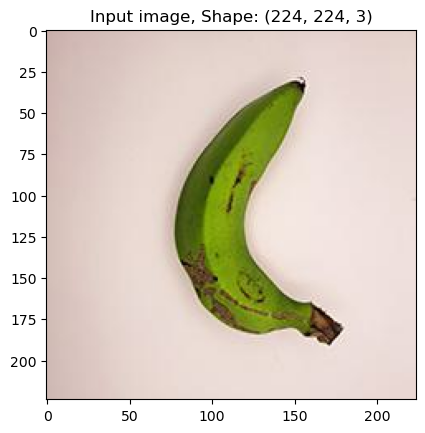

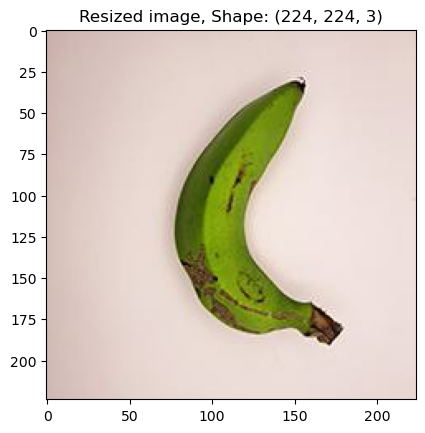

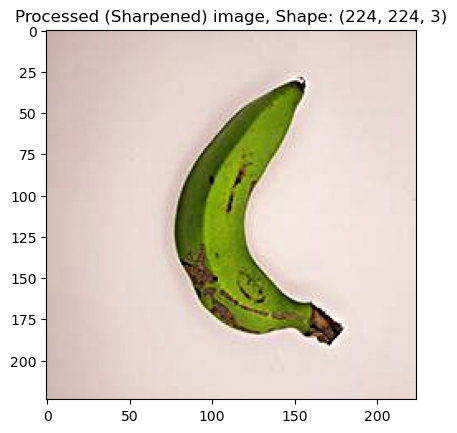

In [7]:
import matplotlib.pyplot as plt

# Last image in the training data
last_index = len(train) - 1

# Input image
Input_image = cv2.imread(train['file'][last_index])
# OpenCV reads the image in BGR, convert it to RGB for displaying it using matplotlib
Input_image_rgb = cv2.cvtColor(Input_image, cv2.COLOR_BGR2RGB)

plt.imshow(Input_image_rgb)
plt.title('Input image, Shape: ' + str(Input_image.shape))
plt.show()

# Assuming 'img' is the resized image from your last iteration, convert it to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title('Resized image, Shape: ' + str(img.shape))
plt.show()

# Assuming 'img_sharp' is the sharpened image from your last iteration, convert it to RGB
img_sharp_rgb = cv2.cvtColor(img_sharp, cv2.COLOR_BGR2RGB)

plt.imshow(img_sharp_rgb)
plt.title('Processed (Sharpened) image, Shape: ' + str(img_sharp.shape))
plt.show()


In [8]:
labels = train['species_num']
labels = to_categorical(labels, num_classes = len(SPECIES))

In [9]:
#CV-Partition
x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.2, random_state=10,)

In [10]:
# Create an ImageDataGenerator object with data augmentation options for image preprocessing
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    rescale=1./255,
     )

datagen.fit(x_train)
#datagen.fit(x_val)

In [11]:
#Input Shape
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (224, 224, 3)


In [12]:
model= tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='sigmoid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [13]:

from sklearn.metrics import classification_report, accuracy_score

model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                       

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='cnn.keras',
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
#early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=9, min_lr=0.1)
#callbacks=[early_stopping, reduce_lr, checkpointer]

In [15]:
#Fit the model
batch_size =32
epochs = 25

In [16]:
history = model.fit(x_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_val, y_val))

Epoch 1/25


113/113 [==============================] - 497s 4s/step - loss: 0.3453 - accuracy: 0.8739 - val_loss: 0.2540 - val_accuracy: 0.9189
Epoch 2/25
113/113 [==============================] - 507s 4s/step - loss: 0.1243 - accuracy: 0.9611 - val_loss: 0.1442 - val_accuracy: 0.9422
Epoch 3/25
113/113 [==============================] - 488s 4s/step - loss: 0.0925 - accuracy: 0.9694 - val_loss: 0.3136 - val_accuracy: 0.8967
Epoch 4/25
113/113 [==============================] - 456s 4s/step - loss: 0.0725 - accuracy: 0.9756 - val_loss: 0.1228 - val_accuracy: 0.9600
Epoch 5/25
113/113 [==============================] - 519s 5s/step - loss: 0.0608 - accuracy: 0.9767 - val_loss: 0.1715 - val_accuracy: 0.9544
Epoch 6/25
113/113 [==============================] - 495s 4s/step - loss: 0.0675 - accuracy: 0.9769 - val_loss: 0.1227 - val_accuracy: 0.9600
Epoch 7/25
113/113 [==============================] - 562s 5s/step - loss: 0.0522 - accuracy: 0.9836 - val_loss: 0.0443 - val_accuracy: 0.98

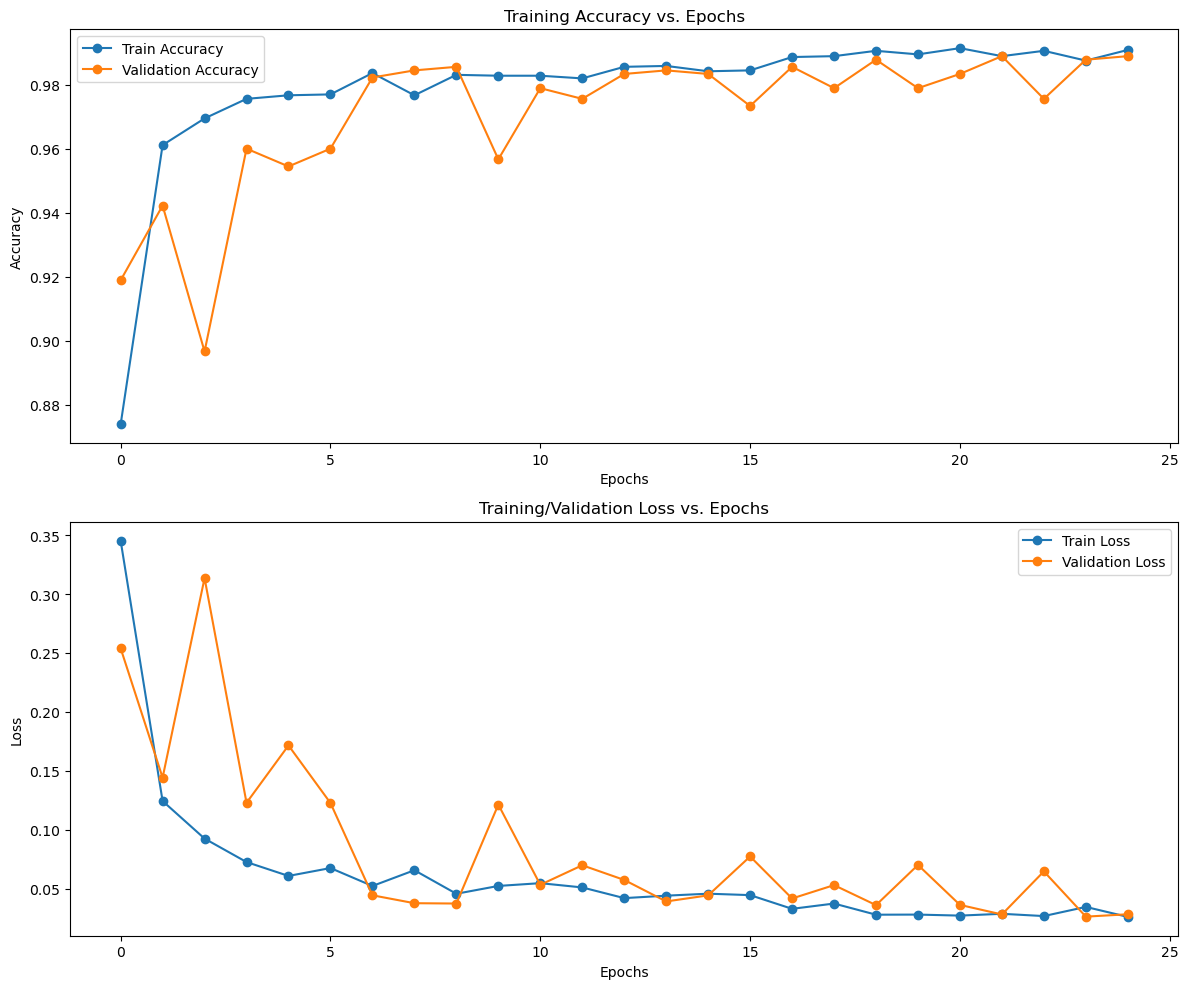

In [17]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

#learning_rate = history.history['lr']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

#ax[2].set_title('Learning Rate vs. Epochs')
#ax[2].plot(learning_rate, 'o-', label='Learning Rate')
#ax[2].set_xlabel('Epochs')
#ax[2].set_ylabel('Loss')
#ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [18]:
model.evaluate(x_train, y_train)
model.evaluate(x_val, y_val)

29/29 [==============================] - 24s 817ms/step - loss: 0.0282 - accuracy: 0.9889


[0.028215941041707993, 0.9888888597488403]

In [19]:
y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis = 1)
y_pred


29/29 [==============================] - 45s 830ms/step


array([2, 2, 2, 1, 1, 0, 1, 2, 0, 2, 2, 0, 0, 0, 1, 0, 2, 2, 0, 1, 1, 1,
       2, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 2, 2, 1, 0, 0, 1, 1, 2, 0, 0, 1,
       1, 0, 0, 1, 0, 2, 0, 0, 1, 2, 2, 0, 2, 0, 0, 1, 2, 0, 1, 0, 2, 2,
       2, 1, 2, 0, 1, 1, 0, 1, 0, 1, 1, 2, 1, 0, 0, 2, 0, 1, 0, 2, 2, 0,
       1, 2, 1, 2, 0, 0, 2, 1, 1, 0, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 0,
       1, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1, 1, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 2, 1, 0, 2, 0, 1, 1, 1, 0, 2, 1,
       0, 2, 0, 1, 1, 2, 0, 0, 0, 2, 1, 0, 1, 1, 1, 1, 0, 2, 0, 1, 2, 2,
       0, 0, 1, 1, 2, 1, 0, 1, 2, 2, 1, 2, 2, 2, 0, 1, 2, 1, 2, 1, 0, 1,
       2, 2, 0, 2, 2, 0, 1, 1, 1, 0, 2, 2, 2, 0, 2, 1, 0, 2, 1, 0, 1, 2,
       1, 1, 0, 0, 1, 1, 1, 2, 1, 2, 0, 2, 2, 1, 0, 2, 0, 0, 2, 1, 1, 0,
       1, 1, 0, 2, 1, 1, 1, 0, 2, 0, 1, 2, 0, 2, 0, 0, 2, 1, 2, 1, 2, 1,
       0, 0, 1, 1, 1, 1, 2, 0, 2, 2, 2, 1, 1, 0, 0, 2, 0, 0, 0, 2, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0,

In [20]:
y_val = np.argmax(y_val, axis = 1)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       297
           1       0.99      0.98      0.98       322
           2       1.00      1.00      1.00       281

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



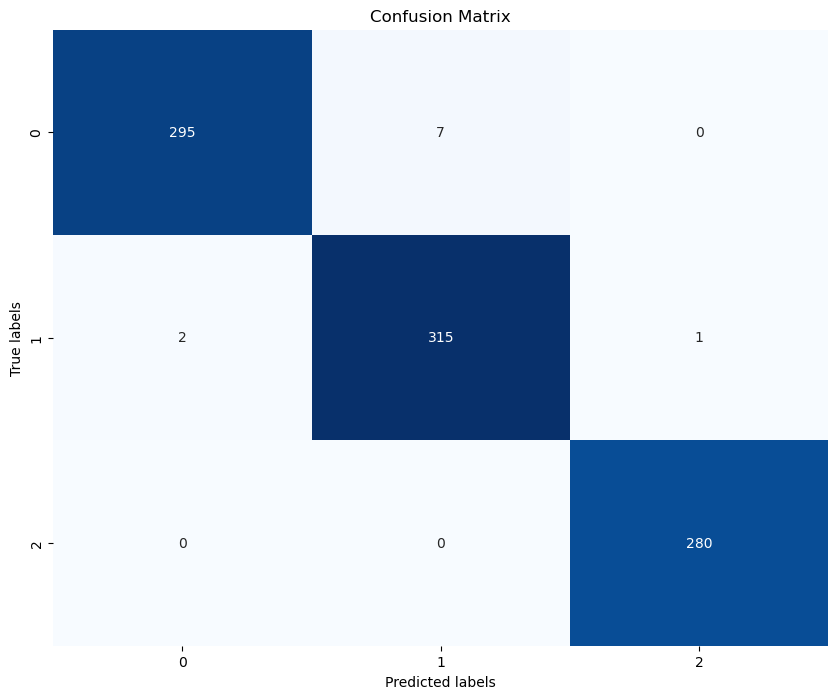

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
def generate_confusion_matrix(y_pred, y_val):
    labels = np.unique(y_val)
    cm = confusion_matrix(y_val, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.title('Confusion Matrix')
    plt.show()

generate_confusion_matrix(y_pred, y_val)